# モデル選択

In [1]:
model_path = "mtgv/MobileVLM_V2-1.7B"
# model_path = "mtgv/MobileVLM_V2-3B"
# model_path = "mtgv/MobileVLM_V2-7B"

# リポジトリクローン、パッケージインストール

In [ ]:
!git clone https://github.com/Meituan-AutoML/MobileVLM.git
%cd MobileVLM

In [ ]:
!pip install -q timm==0.9.12

# インポート

In [4]:
import torch
from PIL import Image

from mobilevlm.model.mobilevlm import load_pretrained_model
from mobilevlm.conversation import conv_templates, SeparatorStyle
from mobilevlm.utils import disable_torch_init, process_images, tokenizer_image_token, KeywordsStoppingCriteria

from mobilevlm.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN

# モデルロード

In [ ]:
disable_torch_init()
tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, False, False)

# 画像読み込み

In [ ]:
# 画像ダウンロード
!wget https://raw.githubusercontent.com/Kazuhito00/Pycon-mini-Tokai-2024-VLM-Colaboratory-Sample/refs/heads/main/image/01.jpg -O test.jpg

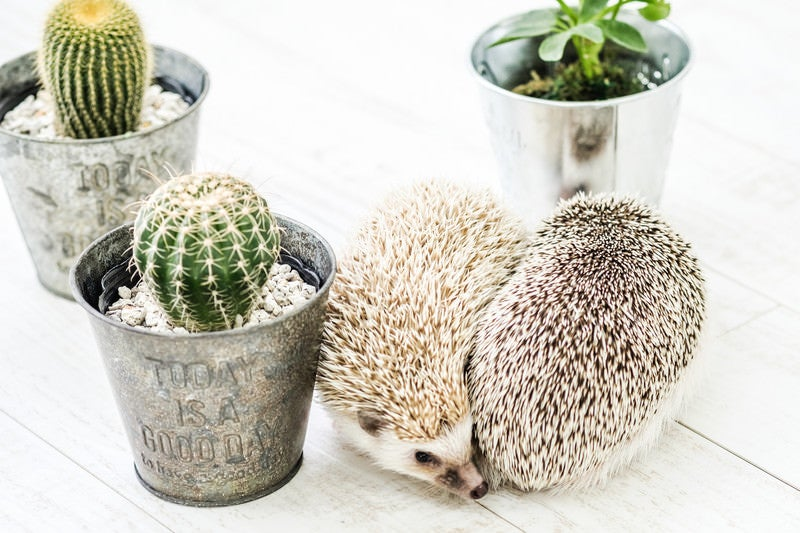

In [7]:
pil_image = Image.open('test.jpg').convert("RGB")
images = [pil_image]
images_tensor = process_images(images, image_processor, model.config).to(model.device, dtype=torch.float16)

pil_image

# VLM設定

In [8]:
prompt = "What does this image show?"

temperature = None  # 0.5など設定する際は、do_sampleをTrueに
do_sample = False
top_p = None
num_beams = 1
max_new_tokens = 512

# 推論

In [11]:
%%time

# プロンプト準備
conv = conv_templates["v1"].copy()
conv.append_message(conv.roles[0], DEFAULT_IMAGE_TOKEN + "\n" + prompt)
conv.append_message(conv.roles[1], None)
input_prompt = conv.get_prompt()

# ID変換
input_ids = (tokenizer_image_token(input_prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).cuda())
stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
stopping_criteria = KeywordsStoppingCriteria([stop_str], tokenizer, input_ids)

# 推論
with torch.inference_mode():
    output_ids = model.generate(
        input_ids,
        images=images_tensor,
        do_sample=do_sample,
        temperature=temperature,
        top_p=top_p,
        num_beams=num_beams,
        max_new_tokens=max_new_tokens,
        use_cache=True,
        stopping_criteria=[stopping_criteria],
    )

# 処理結果デコード
input_token_len = input_ids.shape[1]
n_diff_input_output = (input_ids != output_ids[:, :input_token_len]).sum().item()
if n_diff_input_output > 0:
    print(f"[Warning] {n_diff_input_output} output_ids are not the same as the input_ids")
outputs = tokenizer.batch_decode(output_ids[:, input_token_len:], skip_special_tokens=True)[0]
outputs = outputs.strip()
if outputs.endswith(stop_str):
    outputs = outputs[: -len(stop_str)]

output_text = outputs.strip()

# 表示
print(output_text)
print()

The image shows a group of three small, cute, and furry hedgehogs sitting together in pots.

CPU times: user 671 ms, sys: 0 ns, total: 671 ms
Wall time: 672 ms
